# GLASSY MODULUS

In [1]:
# import required packages
import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import layers
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [2]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\01-Research\01-Data\01-Glassy_Modulus.csv"
df = pd.read_csv(filePath)

In [3]:
#
smiles = df['SMILES']
smiles = [list(smile.strip('{} ').split(',')) for smile in smiles]
temperature_data = df['Tg']
molar_ratio = df['Molar Ratio']
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(':')]
    m_r.append(ratio_list)

In [4]:
''''
functions for fingerprinting and multiplication of 
fingerprinted monomers by their respective molar ratios
'''
#function for fingerprinting
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 10, 1024)
    return fp

#function for storing fingerprints monomers as a representation of the polymers
def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp

# function for multiplication by their respective molar ratios
def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)

fingerprinted_polymer_data = []
for polymer, polymer_m_r in zip(smiles, m_r):
    fingerprinted_polymer = fingerprint_polymer(polymer)
    multiplied_polymer = [multiply_fingerprint(fp, m_r_value) for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)]
    fingerprinted_polymer_data.append(multiplied_polymer)
    

#flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

#find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode = 'constant') for arr in flattened_arr]

new_array = np.stack(padded_arrays)

In [5]:
new_array.shape

(260, 4096)

In [6]:
# X = new_array
# y = df['Glassy Modulus(GPa)'] #specify y

In [7]:
# #Split data into training and testing sets
# random_seed = 10
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= random_seed)

x_plot = np.linspace(0, 12)
y_plot = x_plot

### ANN Model

Epoch 1/100
11/11 [==============================] - 9s 155ms/step - loss: 7.5782 - val_loss: 4.9232
Epoch 2/100
11/11 [==============================] - 1s 58ms/step - loss: 4.1408 - val_loss: 2.7665
Epoch 3/100
11/11 [==============================] - 1s 75ms/step - loss: 2.7788 - val_loss: 2.8428
Epoch 4/100
11/11 [==============================] - 1s 66ms/step - loss: 2.9512 - val_loss: 2.6827
Epoch 5/100
11/11 [==============================] - 1s 68ms/step - loss: 2.4744 - val_loss: 2.4755
Epoch 6/100
11/11 [==============================] - 1s 51ms/step - loss: 2.5228 - val_loss: 2.4134
Epoch 7/100
11/11 [==============================] - 1s 64ms/step - loss: 2.5484 - val_loss: 2.4873
Epoch 8/100
11/11 [==============================] - 1s 62ms/step - loss: 2.4372 - val_loss: 2.4152
Epoch 9/100
11/11 [==============================] - 1s 71ms/step - loss: 2.4957 - val_loss: 2.6756
Epoch 10/100
11/11 [==============================] - 1s 52ms/step - loss: 2.5528 - val_loss: 2.424

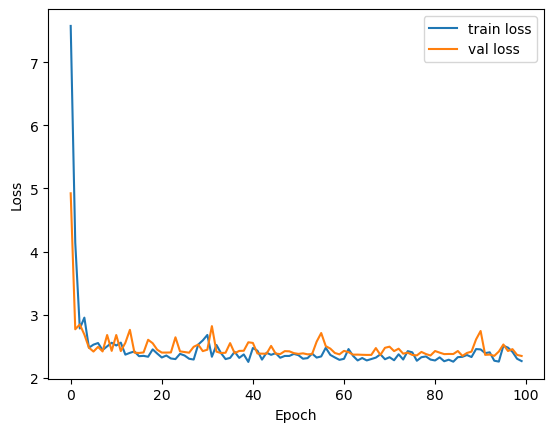

2/2 [==============================] - 0s 23ms/step


In [8]:
X =new_array.reshape(-1, 4096, 1)
y = df['Glassy Modulus(GPa)'] 
# Assuming you have your fingerprinted SMILES data (fingerprinted_data) and numerical glass transition temperature data (temperature_data)
# and corresponding target values (rubbery_modulus_targets)

# Split the data into train and test sets
data_train, data_test, temperature_train, temperature_test, targets_train, targets_test = train_test_split(
    X, temperature_data, y, test_size=0.2, random_state=42
)

# Define the CNN branch for fingerprinted SMILES data
data_input = keras.layers.Input(shape=(4096, 1))
data_conv = keras.layers.Conv1D(32, kernel_size=3, activation='relu')(data_input)
data_pool = keras.layers.GlobalMaxPooling1D()(data_conv)

# Define the MLP branch for numerical glass transition temperature data
temperature_input = keras.layers.Input(shape=(1,))
temperature_dense = keras.layers.Dense(32, activation='relu')(temperature_input)

# Merge the two branches
merged = keras.layers.Concatenate()([data_pool, temperature_dense])

# Add fully connected layers for prediction
merged_dense = keras.layers.Dense(64, activation='relu')(merged)
output = keras.layers.Dense(1)(merged_dense)

# Create the dual input model
model = keras.models.Model(inputs=[data_input, temperature_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
history = model.fit(
    [data_train, temperature_train],
    targets_train,
    epochs=100,
    batch_size=20,
    validation_data=([data_test, temperature_test], targets_test)
)

# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Make predictions
predictions = model.predict([data_test, temperature_test])

# Evaluate the model further if needed


# RUBBERY MODULUS

In [9]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import layers
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [10]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\01-Research\01-Data\00-Original.csv"
df = pd.read_csv(filePath)

In [11]:
#
smiles = df['SMILES']
smiles = [list(smile.strip('{} ').split(',')) for smile in smiles]
temperature_data = df['Tg']
molar_ratio = df['Molar Ratio']
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(':')]
    m_r.append(ratio_list)

In [12]:
''''
functions for fingerprinting and multiplication of 
fingerprinted monomers by their respective molar ratios
'''
#function for fingerprinting
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 10, 128)
    return fp

#function for storing fingerprints monomers as a representation of the polymers
def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp

# function for multiplication by their respective molar ratios
def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)

fingerprinted_polymer_data = []
for polymer, polymer_m_r in zip(smiles, m_r):
    fingerprinted_polymer = fingerprint_polymer(polymer)
    multiplied_polymer = [multiply_fingerprint(fp, m_r_value) for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)]
    fingerprinted_polymer_data.append(multiplied_polymer)
    

#flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

#find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode = 'constant') for arr in flattened_arr]

new_array = np.stack(padded_arrays)

In [13]:
new_array.shape

(260, 512)

In [14]:
# X = new_array
# y = df['Rubbery modulus'] #specify y

In [15]:
#Split data into training and testing sets
# random_seed = 10
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= random_seed)

x_plot = np.linspace(0, 12)
y_plot = x_plot

Epoch 1/500
7/7 [==============================] - 5s 108ms/step - loss: 26.3519 - val_loss: 20.2422
Epoch 2/500
7/7 [==============================] - 0s 25ms/step - loss: 20.0300 - val_loss: 20.7720
Epoch 3/500
7/7 [==============================] - 0s 27ms/step - loss: 20.6599 - val_loss: 20.9647
Epoch 4/500
7/7 [==============================] - 0s 26ms/step - loss: 20.3443 - val_loss: 20.3514
Epoch 5/500
7/7 [==============================] - 0s 29ms/step - loss: 19.8356 - val_loss: 20.0416
Epoch 6/500
7/7 [==============================] - 0s 27ms/step - loss: 19.8361 - val_loss: 20.0190
Epoch 7/500
7/7 [==============================] - 0s 27ms/step - loss: 19.8390 - val_loss: 20.0232
Epoch 8/500
7/7 [==============================] - 0s 27ms/step - loss: 19.8186 - val_loss: 20.0779
Epoch 9/500
7/7 [==============================] - 0s 28ms/step - loss: 19.8174 - val_loss: 20.0998
Epoch 10/500
7/7 [==============================] - 0s 28ms/step - loss: 19.8042 - val_loss: 20.077

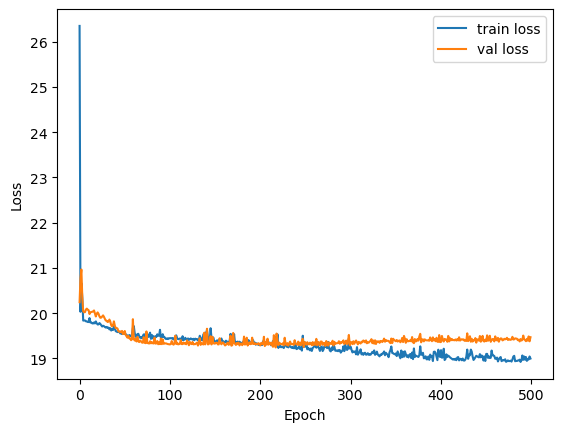

2/2 [==============================] - 0s 5ms/step


In [16]:
# import required packages
X =new_array.reshape(-1, 512, 1)
y = df['Rubbery Modulus (MPa)'] #specify y

# Assuming you have your fingerprinted SMILES data (fingerprinted_data) and numerical glass transition temperature data (temperature_data)
# and corresponding target values (rubbery_modulus_targets)

# Split the data into train and test sets
data_train, data_test, temperature_train, temperature_test, targets_train, targets_test = train_test_split(
    X, temperature_data, y, test_size=0.2, random_state=42
)

# Define the CNN branch for fingerprinted SMILES data
data_input = keras.layers.Input(shape=(512, 1))
data_conv = keras.layers.Conv1D(32, kernel_size=3, activation='relu')(data_input)
data_pool = keras.layers.GlobalMaxPooling1D()(data_conv)

# Define the MLP branch for numerical glass transition temperature data
temperature_input = keras.layers.Input(shape=(1,))
temperature_dense = keras.layers.Dense(32, activation='relu')(temperature_input)

# Merge the two branches
merged = keras.layers.Concatenate()([data_pool, temperature_dense])

# Add fully connected layers for prediction
merged_dense = keras.layers.Dense(64, activation='relu')(merged)
output = keras.layers.Dense(1)(merged_dense)

# Create the dual input model
model = keras.models.Model(inputs=[data_input, temperature_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
history = model.fit(
    [data_train, temperature_train],
    targets_train,
    epochs=500,
    batch_size=32,
    validation_data=([data_test, temperature_test], targets_test)
)

# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Make predictions
predictions = model.predict([data_test, temperature_test])

# Evaluate the model further if needed
